# CMA/ES - Hierarchical - Bays09 - 1th try: LL92, lapse + sigma_base

First try of Hierarchical optimisation

In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [32]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [33]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_ll92_1try_Mratiosigmaxsigmabaselinelapserate_repetitions3_020817/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-4e590f5b-7749-41b4-8ba1-269e71b623d3.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_bays09_ll92_1try_Mratiosigmaxsigmabaselinelapserate_repetitions3_020817


In [34]:
dataio = DataIO(label='cmaes_hier_bays09', 
                calling_function='', 
                output_folder='./outputs/')

=== FileIO ready: ./outputs/cmaes_hier_bays09-c6f525a3-5541-48ac-92bb-6aec516dab29 ===


In [35]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [36]:
parameter_names_sorted

['M', 'lapse_rate', 'ratio_hierarchical', 'sigma_baseline', 'sigmax']

In [37]:
metric = 'dist_nll92'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])
df_all_fits.loc[:, 'M'] = df_all_fits['M'].astype(int)

In [39]:
# Fix M and ratio_conj
ratio_hierarchical, M_lower, M_higher = utils.fix_ratiohierarchical(
    df_all_fits['M'], df_all_fits['ratio_hierarchical'])
df_all_fits.loc[:, 'ratio_hierarchical'] = ratio_hierarchical
df_all_fits.loc[:, 'M_lower'] = M_lower
df_all_fits.loc[:, 'M_higher'] = M_higher

In [40]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 2000000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

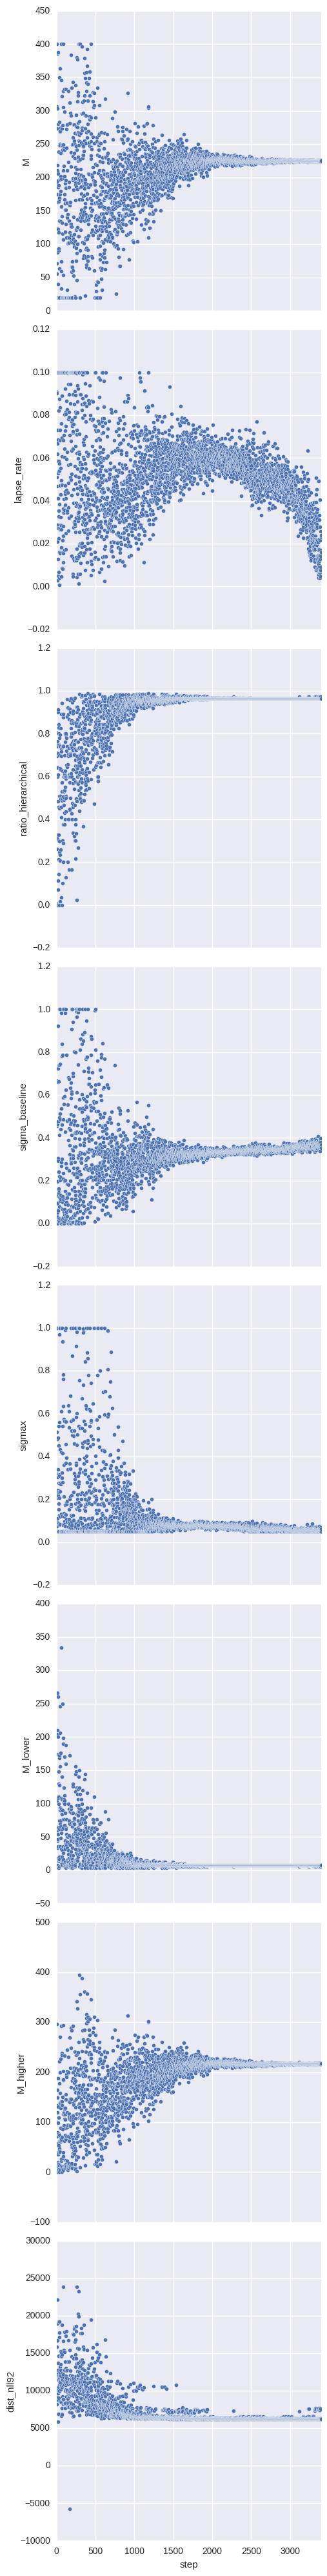

In [42]:
# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted + ['M_lower', 'M_higher', metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))
# dataio.save_current_figure('cmaes_traj_{label}_{unique_id}.pdf')

# Check parameters effects
# sns.pairplot(df_best_fits,
#              x_vars=parameter_names_sorted,
#              y_vars=[metric],
#             )



In [25]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] < 1000]
# result_to_color = np.array(df_cmaes_traj['dist_nll92'])
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.log(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj['M'],
        y = df_cmaes_traj['lapse_rate'],
        z = df_cmaes_traj['sigma_baseline'],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title='M',
        ),
        yaxis=go.YAxis(
            title='lapse_rate',
        ),
        zaxis=go.ZAxis(
            title='sigma_baseline',
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [44]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(20).median().to_dict()
df_bestparams

{'M': 225.0,
 'M_higher': 217.0,
 'M_lower': 8.0,
 'dist_nll92': 6270.6196645257187,
 'lapse_rate': 0.013546490752306049,
 'ratio_hierarchical': 0.96444444444444444,
 'sigma_baseline': 0.3706964383075087,
 'sigmax': 0.056634538777951722,
 'step': 3389.5}

In [18]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             type_layer_one='feature',
                             output_both_layers=None,
                             normalise_weights=1,
                             ratio_hierarchical=0.5,
                             threshold=1.0,                  
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='hierarchical',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=1500, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

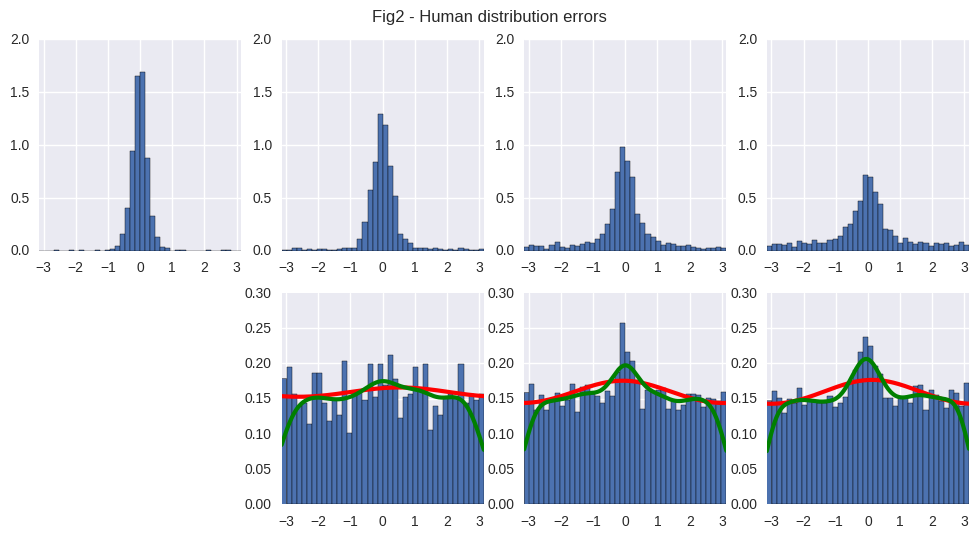

In [19]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

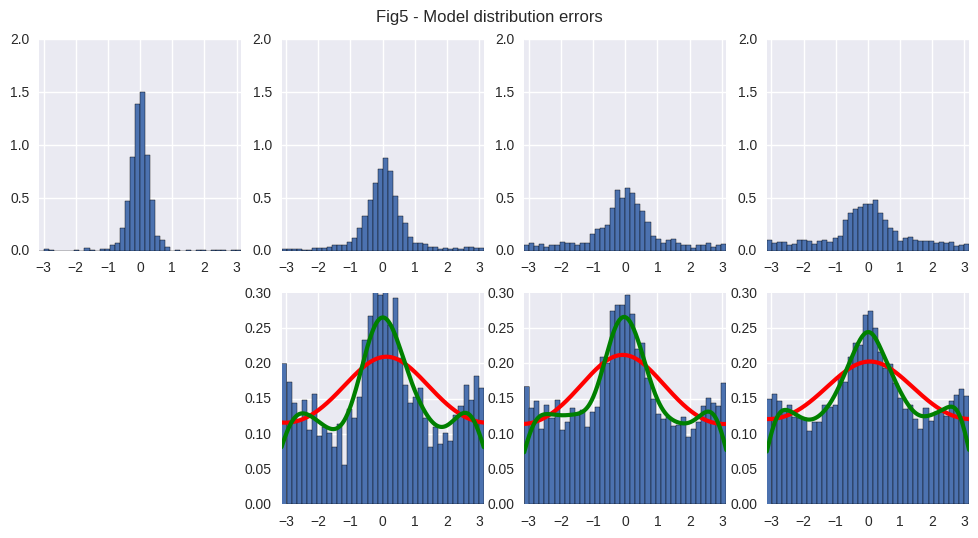

In [20]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

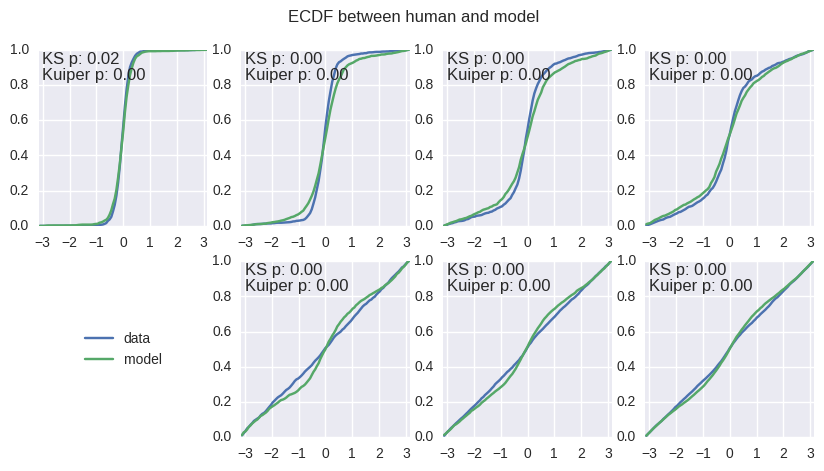

In [21]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((10, 5))

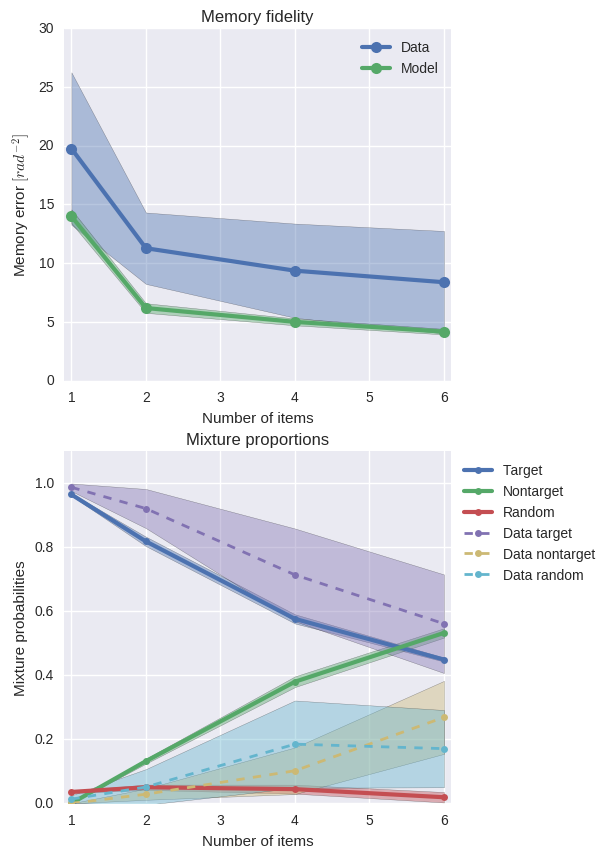

In [22]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

# Discussion:

